In [1]:
#get some library
import pandas as pd
import seaborn as sns
from Bio import SeqIO
import numpy as np
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools

from ipywidgets import widgets
from IPython.display import display
from plotly.widgets import GraphWidget

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
init_notebook_mode(connected=True)

<IPython.core.display.Javascript object>

In [2]:
#get only the gene id from
#the new TryTripDB format
def clean_id(temp_id):
    if str(temp_id) == 'nan':
        return 'nan'
    temp_id = temp_id.split(';')[0].split(':')[0]
    if temp_id.count('.')>2:
        temp_id = '.'.join(temp_id.split('.')[0:3])
    return temp_id

#helper function to print out
#the protein removed at each threshold
def print_result(start_df_shape, shape_before, df, what):
    removed = shape_before[0]- df.shape[0]
    removed_from_beginning = start_df_shape[0]-df.shape[0]
    if removed > 0:
        print ('removed ',removed, what )  
        print ('tot ', removed_from_beginning, ' entries removed' )
        print ('---------------')
    else:
        print (what)
        print ('nothing removed')
        print ('---------------')

#remove rubbish entires from a
#maxquant output
def clean(df):  
    #remove Only identified by site
    before,start = df.shape,df.shape
    col = 'Only identified by site'
    df = df[df[col] != '+'] 
    print_result(start, before, df, col)
    
    #remove hits from reverse database
    before = df.shape
    col = 'Reverse'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
        
    #remove contaminants (mainly keratine and bsa)
    before = df.shape
    col = 'Potential contaminant'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
    
    ##remove protein groups with less thatn 2 unique peptides
    #before = df.shape
    #col = 'Peptide counts (unique)'
    #df['unique'] = [int(n.split(';')[0]) for n in df[col]]
    #df = df[df['unique'] >= 2]
    #print_result(start, before, df, col)
    return df

In [5]:
#add back the description of the proteins
desc_dict = {}
path = '../TriTrypDB-40_TbruceiTREU927_AnnotatedProteins_VSG.fasta'
with open(path, "r") as handle:
    a=0
    for record in SeqIO.parse(handle, "fasta"):
        a+=1
        temp_id = clean_id(record.id).strip()
        temp_desc = record.description.split('|')[4].strip()
        #print  (record.description.split('|'))
        if '=' in temp_desc:
            temp_desc=temp_desc.split('=')[1]
        desc_dict[temp_id]=temp_desc

desc_dict['Tb427.BES40.22']='main vsg'

In [6]:
desc_dict['Tb927.1.100']

'RNA polymerase (pseudogene), putative'

In [11]:
df = pd.read_csv('txt/proteinGroups.txt',sep='\t')
df = clean(df)
df['Gene_id'] = [clean_id(n.split(';')[0]) for n in df['Protein IDs']]
df['Gene_desc'] = [desc_dict[n] for n in df['Gene_id']]
df.set_index('Gene_id',inplace=True)

norm_factor = df['LFQ intensity 2'].mean()+df['LFQ intensity 1'].mean()
df['fc']= (df['LFQ intensity 1']+norm_factor)/(df['LFQ intensity 2']+norm_factor)
df['fc']= np.log2(df['fc'])
df['log10_score'] = np.log10(df['Score'])
df[['Gene_desc','LFQ intensity 2','LFQ intensity 1','log10_score','fc']].to_csv('table.csv')
df[['Gene_desc','log10_score','fc']].sort_values(['fc','log10_score'], ascending=False).head(10)

removed  44 Only identified by site
tot  44  entries removed
---------------
removed  29 Reverse
tot  73  entries removed
---------------
removed  27 Potential contaminant
tot  100  entries removed
---------------


,Gene_desc,log10_score,fc
Gene_id,,,
Tb927.3.2050,Minicircle replication factor 172,2.509619,1.498995
Tb927.3.3270,"ATP-dependent 6-phosphofructokinase, glycosomal",2.509619,1.375942
Tb11.v5.0765,N-acetylglucosaminyl-phosphatidylinositol bios...,2.064944,1.333400
Tb927.1.3070,"hypothetical protein, conserved",2.509619,1.142963
Tb927.10.13800,"hypothetical protein, conserved",2.509619,1.131649
Tb927.6.4100,"hypothetical protein, conserved",2.442746,1.116642
Tb927.2.380,"retrotransposon hot spot protein 2 (RHS2), put...",2.509619,0.983195
Tb927.6.4300,"glyceraldehyde 3-phosphate dehydrogenase, glyc...",2.509619,0.933748
Tb927.7.2330,"Protein of unknown function (DUF1663), putative",2.372249,0.922003


In [12]:
df['combined_intensity'] = np.log10(df['LFQ intensity 2']+df['LFQ intensity 1']+1)
df['LFQ_2log'] = np.log10(df['LFQ intensity 2'])

# Lfq Plot

,Gene_desc,log10_score,fc
Gene_id,,,
Tb927.10.3900,"CAMK/CAMKL family protein kinase, putative",1.437624,0.0
Tb927.6.4330,"hypothetical protein, conserved",1.277976,0.0
Tb927.4.3040,Enriched in surface-labeled proteome protein 11,1.132420,0.0
Tb927.11.10820,"Casein kinase II subunit beta, putative",1.127429,0.0
Tb927.11.3530,NADH dehydrogenase (ubiquinone) 1 alpha subcom...,1.075182,0.0
Tb927.11.16380,"TPR repeat, putative",1.050264,0.0
Tb927.11.7670,"Cornifin (SPRR) family, putative",0.905305,0.0
Tb927.6.3170,"hypothetical protein, conserved",0.864897,0.0
Tb927.8.4670,"hypothetical protein, conserved",0.863507,0.0


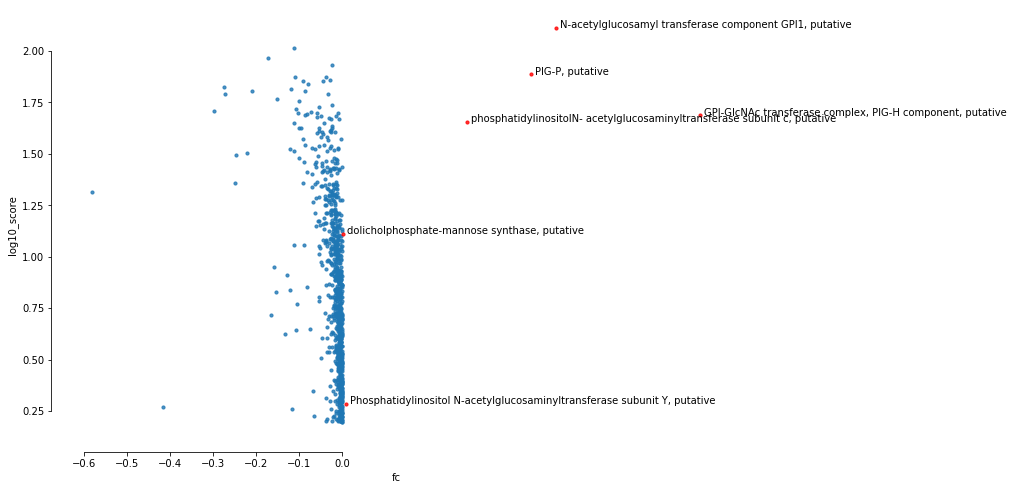

In [20]:
#selection = df[df['Score']>5]
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='fc', y='log10_score', 
            fit_reg=False, data = df[df['LFQ intensity 1']==0],
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=10, trim=True)

prots_to_annotate ='''Tb927.10.6140
Tb927.5.3680
Tb927.10.10110
Tb927.3.4570
Tb927.4.780
Tb927.10.4610'''.split('\n')
#Tb927.2.1780
#Tb927.9.6440
#prots_to_annotate = [
#    'Tb11.v5.0765',#'Tb927.2.1780',
#    'Tb927.10.6140',
#    'Tb927.5.3680',
#    'Tb927.10.10110',
#    'Tb927.3.4570',
#    'Tb927.4.780',
    #'Tb927.9.6440',
#    ]
sns.regplot(x='fc', y='log10_score', 
            fit_reg=False, data = df.loc[prots_to_annotate],
            ax=ax, scatter_kws={'s':10, 'color':'red'})

for prot in prots_to_annotate:
    x = df.loc[[prot]]['fc']
    y= df.loc[[prot]]['log10_score']
    ax.annotate(desc_dict[prot],(x,y), xytext=(x+0.01,y))
#plt.tight_layout()
plt.savefig('LFQ.svg') 
plt.savefig('LFQ.png')
df[df['LFQ intensity 1']==0][['Gene_desc','log10_score','fc']].sort_values(['fc','log10_score'], ascending=False).head(10)

# Ibaq Plot

,Gene_desc,log10_score,fc3
Gene_id,,,
Tb927.10.3900,"CAMK/CAMKL family protein kinase, putative",1.437624,1.0
Tb927.6.4330,"hypothetical protein, conserved",1.277976,1.0
Tb927.4.3040,Enriched in surface-labeled proteome protein 11,1.132420,1.0
Tb927.11.10820,"Casein kinase II subunit beta, putative",1.127429,1.0
Tb927.11.3530,NADH dehydrogenase (ubiquinone) 1 alpha subcom...,1.075182,1.0
Tb927.11.16380,"TPR repeat, putative",1.050264,1.0
Tb927.11.7670,"Cornifin (SPRR) family, putative",0.905305,1.0
Tb927.6.3170,"hypothetical protein, conserved",0.864897,1.0
Tb927.8.4670,"hypothetical protein, conserved",0.863507,1.0


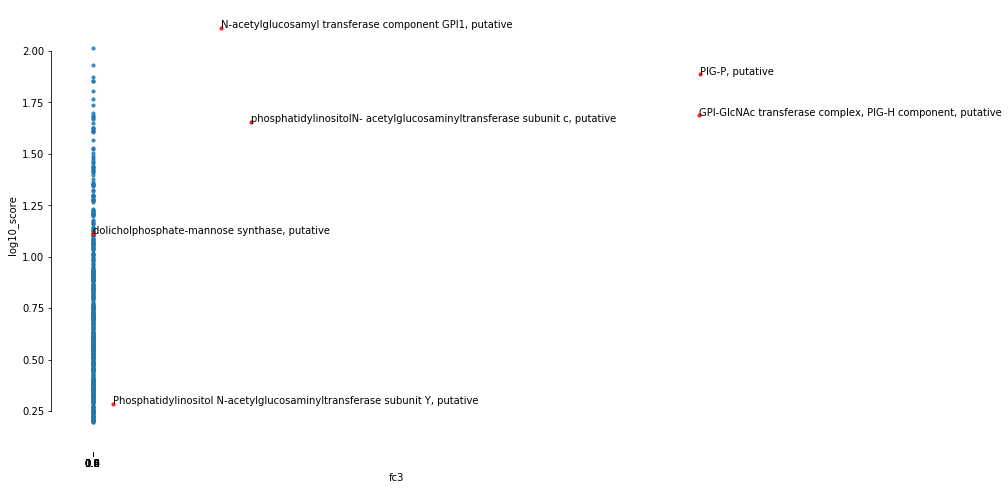

In [21]:
df['fc3']=(df['iBAQ 1']+1)/(df['iBAQ 2']+1)

#selection = df[df['Score']>5]
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='fc3', y='log10_score', 
            fit_reg=False, data = df[df['iBAQ 1']==0],
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=10, trim=True)


sns.regplot(x='fc3', y='log10_score', 
            fit_reg=False, data = df.loc[prots_to_annotate],
            ax=ax, scatter_kws={'s':10, 'color':'red'})

for prot in prots_to_annotate:
    x = df.loc[[prot]]['fc3']
    y= df.loc[[prot]]['log10_score']
    ax.annotate(desc_dict[prot],(x,y), xytext=(x+0.01,y))

df[['Gene_desc','fc3']].sort_values('fc3',ascending=False)

plt.savefig('iBAQ.svg') 
plt.savefig('iBAQ.png')
#norm_factor = df['LFQ intensity 2'].mean()+df['LFQ intensity 1'].mean()
#df['fc']= (df['LFQ intensity 2']+norm_factor)/(df['LFQ intensity 1']+norm_factor)

temp = df[['Gene_desc','fc','fc3','LFQ intensity 1','LFQ intensity 2','iBAQ 1','iBAQ 2']]
temp.columns = ['Gene_desc','lfq_rank','ibaq_rank','LFQ intensity 1','LFQ intensity 2','iBAQ 1','iBAQ 2']
temp.to_csv('table.csv')

df[df['iBAQ 1']==0][['Gene_desc','log10_score','fc3']].sort_values(['fc3','log10_score'], ascending=False).head(10)